In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

from assimulo.solvers import IDA
from assimulo.problem import Implicit_Problem
from assimulo.exception import TerminateSimulation

from scipy.optimize import curve_fit

%matplotlib inline

Could not find cannot import name 'radau5' from 'assimulo.lib' (C:\Users\moone\Anaconda3\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'dopri5' from 'assimulo.lib' (C:\Users\moone\Anaconda3\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (C:\Users\moone\Anaconda3\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (C:\Users\moone\Anaconda3\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


Euqations governing lithium concentration in each electrode
$$
\frac{d\bar{x_p}}{dt} + 15 \frac{D_p}{R_p^2}(\bar{x_p} - x_{p,r=1}) = 0
$$

$$
\frac{d\bar{x_n}}{dt} + 15 \frac{D_n}{R_n^2}(\bar{x_n} - x_{n,r=1}) = 0
$$

Equations relating particle flux at to the lithium concentration
$$
J_P + 5\frac{D_p c_{p,\mbox{max}}}{R_p}( x_{p,r=1} - \bar{x_p}) = 0
$$

$$
J_n + 5\frac{D_n c_{n,\mbox{max}}}{R_n}( x_{n,r=1} - \bar{x_n}) = 0
$$

Equations relating particle flux to over-potential
$$
J_p = k_p c_{p,\mbox{max}} (1 - x_{p,r=1})^{0.5} x_{p,r=1}^{0.5}c_e^{0.5} \left[
e^{\frac{0.5F}{RT}\eta_p} - e^{\frac{-0.5F}{RT}\eta_p}
\right]
$$

$$
J_n = k_n c_{n,\mbox{max}} (1 - x_{n,r=1})^{0.5} x_{n,r=1}^{0.5}c_e^{0.5} \left[
e^{\frac{0.5F}{RT}\eta_n} - e^{\frac{-0.5F}{RT}\eta_n}
\right]
$$

The relation between current, particle flux and electroactive surface area.
$$I = J_p F S_p = -J_n F S_n$$

Over-potential is related to the electrode  potential and open circuit voltage
$$\eta_p = \Phi_p - U_p$$

$$\eta_n = \Phi_n - U_n$$

And lastly, the cell voltage is given by,
$$V = \Phi_p - \Phi_n$$



The open circuit voltages $U_p$ and $U_n$ will be constructed through cubic spline interpolations.

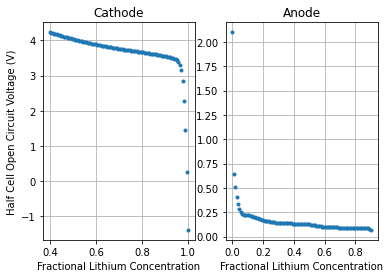

In [2]:
#  Pull in experimental data for the open circuit potential
ocpp_data = np.loadtxt('positive.dat')
ocpn_data = np.loadtxt('negative.dat')

#  Visualize the data for both electrodes
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(ocpp_data[:,0], ocpp_data[:,1], '.')
ax1.set_xlabel('Fractional Lithium Concentration')
ax1.set_ylabel('Half Cell Open Circuit Voltage (V)')
ax1.set_title('Cathode')
ax1.grid(True)

ax2.plot(ocpn_data[:,0], ocpn_data[:,1], '.')
ax2.set_xlabel('Fractional Lithium Concentration')
ax2.set_title('Anode')
ax2.grid(True)

##  Problem Statement

We discharge the cell at a constant current recording the voltage at a series of times.  Can we determine the diffusion constant of the cathode ($D_p$), and the electroactive surface area of both electrodes ($S_p$ and $S_n$).

Text(0.5, 1.0, 'Experimental Data')

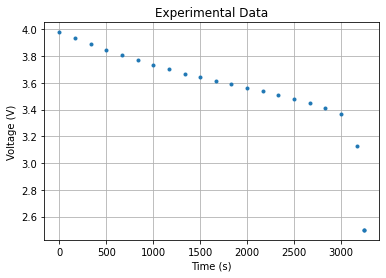

In [3]:
#  Visulaize our experimental data. We whish to pull model parameters, D_p, S_p and S_n from this data
data = np.loadtxt('experimental_data.dat')

plt.plot(data[:,0,], data[:,1], '.')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.title('Experimental Data')

In [4]:
class Battery_Model:
    def __init__(self):
        self.c_p_max = 59490    #  Max cathode Li concentration
        self.R_p = 5e-6         # Cathode particle radius
        self.c_n_max = 30560    #  Max anode Li concentration
        self.R_n = 15e-6        #  Anode particle radius
        self.c_e = 1000         #  Electrolyte Li concentration
        self.F = 96485.3415     #  Faraday's constant
        self.R = 8.314472       #  Ideal gas constant
        self.D_n = 7.05077e-11  #  Anonde diffusion
        self.k_p = 2.19185e-07 # k_p
        self.k_n = 1.01485e-09 # k_n
        self.T_cell = 298
        
        self.xp = 0.470081    # x_p
        self.xn = 0.53736     # x_n
        
        self.I_in = -15         #  Discharge current
        self.cutoff = 2.5       #  Minimum cell voltage
        
        #  Load in out OCP data which we will use to build  interpolating splines
        ocpp_data = np.loadtxt('positive.dat')
        ocpn_data = np.loadtxt('negative.dat')
        
        #  Build interpolating spline objects
        self.ocp_p = CubicSpline(ocpp_data[:,0], ocpp_data[:,1])
        self.ocp_n = CubicSpline(ocpn_data[:,0], ocpn_data[:,1])
    
    #  Define our model equations.  This function is of the form: 0 = f(t, x, xprime)
    def res(self, t, x, xprime, sw):
        x_p    = x[0]
        xs_p   = x[1]
        x_n    = x[2]
        xs_n   = x[3]
        eta_p  = x[4]
        eta_n  = x[5]
        U_p    = x[6]
        U_n    = x[7]
        phi_p  = x[8]
        phi_n  = x[9]
        V      = x[10]
        
        #  Extract our parameters
        D_p = self.D_p
        S_p = self.S_p
        S_n = self.S_n
        
        #  Calculate particle fluxes
        J_p = self.I_in / (self.F * S_p);
        J_n = -self.I_in / (self.F * S_n);
            
        res = np.zeros(11)
            
        res[0] = xprime[0] + (15*D_p/self.R_p**2 * ( x_p - xs_p) )
        res[1] = J_p + ( 5*D_p * self.c_p_max/self.R_p ) * ( xs_p - x_p )

        res[2] = xprime[2] + ( 15*self.D_n*1e-8/self.R_n**2 * ( x_n - xs_n ) )
        res[3] = J_n * ( 5*self.D_n * self.c_n_max/self.R_n ) * ( xs_n - x_n )
            
        res[4] = self.k_p * self.c_p_max * ( 1 - xs_p)**0.5 * xs_p**0.5 * self.c_e**0.5 * (np.exp(0.5 * self.F / self.R / self.T_cell * eta_p)  - np.exp(-0.5 * self.F / self.R / self.T_cell * eta_p) ) - J_p
        res[5] = self.k_n * self.c_n_max * ( 1 - xs_n)**0.5 * xs_n**0.5 * self.c_e**0.5 * (np.exp(0.5 * self.F / self.R / self.T_cell * eta_n)  - np.exp(-0.5 * self.F / self.R / self.T_cell * eta_n) ) - J_n

        res[6] = U_p - self.ocp_p( xs_p )
        res[7] = U_n - self.ocp_n( xs_n )
            
        res[8] = phi_p - eta_p - U_p
        res[9] = phi_n - eta_n - U_n

        res[10] = V - phi_p + phi_n
            
        return res
        
    def state_events(self, t, x, xprime, sw):
        #  Termnate when cell voltage reaches the cutoff
        e = np.ones( x.shape )
        e[-1] = x[-1] - self.cutoff

        return e

    def handle_event(self, solver, event_info):
        raise TerminateSimulation
        
    def run_simulation(self, D_p, S_p, S_n, ncp_list = None):
        
        #  Set out parameters so we can use them in the model code
        self.S_p = S_p
        self.S_n = S_n
        self.D_p = D_p
        
        #  Allocate vector our initial conditions
        x0 = np.zeros(11)
        
        #  Our initial guesses
        x0[0] = self.xp
        x0[1] = self.xp
        x0[2] = self.xn
        x0[3] = self.xn
        x0[4] = 0
        x0[5] = 0
        x0[6] = 0
        x0[7] = 0
        x0[8] = 0
        x0[9] = 0
        x0[10] = 4
        
        #  We will guess all zeros for the derivative vector
        xprime0 = np.zeros( 11 )
        
        #  Set starting time to zero
        t0 = 0
        
        #  We will use this as our integration time if we do not send in a list of time steps explicitly
        tspan = 4000
        
        #  Switch variable  We don't use this, but it needs to be passed into the solver.
        sw0 = [False, False, False, False, False, False, False, False,
            False, False, False]
        
        #  Define our algebraic variables
        algvar = [True, False, True, False, False, False, False, False,
             False, False, False]
        
        #  Initialize our model
        model = Implicit_Problem(self.res, x0, xprime0, t0, sw0 = sw0)
        
        #  Attach event function to the model
        model.state_events = self.state_events
        model.handle_event = self.handle_event
        
        #  Create the simulation object and attach our algvars
        sim = IDA(model)
        sim.algvar = algvar
        
        #  Find initial conditions
        sim.make_consistent('IDA_YA_YDP_INIT')
        
        #  Solve the sytem  we either use our tspan ot time list.
        if ncp_list is not None:
            self.t, self.x, xp = sim.simulate(ncp_list[-1], 0, ncp_list)
        else:
            self.t, self.x, xp = sim.simulate(tspan, 100)
        
        #  ach the volatge solution to a class variable
        self.V = self.x[:, -1]
    
    #  Our fitting model
    def objective(self, t, D_p, S_p, S_n):
        
        #  Set call variables
        D_p = 10**D_p
        S_p = 10**S_p
        S_n = 10**S_n
        
        #  Run simulation passing in our time steps
        self.run_simulation(D_p, S_p, S_n, ncp_list = t)
        
        #  Get the voltage from the solution matrix
        V = self.x[:, -1]
        
        #  There can be cases where the simulation terminates early and doesn't have
        # the same nnumber of points as t.  In this case, we pad the end of V with zeros.
        if t.size > V.size:
            padding = np.zeros( (t.size - V.size, ) )
            V = np.concatenate( (V, padding) )
                
        return V
    
    #  Call this function to run the fitting routine
    def do_fit(self):
        data = np.loadtxt('experimental_data.dat')
        
        #  Guesses for the log of our parameters.  Must be doubles rather than ints
        p0 = [-13., 1., 1.]
        
        #  Call the curve fit function
        p, pcov = curve_fit(self.objective, data[:,0], data[:,1], p0 = p0)
            
        print( np.power(10, p) )
        
        return p

Terminating simulation at t = 3226.180104 after signal from handle_event.
Final Run Statistics: --- 

 Number of steps                                 : 93
 Number of function evaluations                  : 165
 Number of Jacobian evaluations                  : 33
 Number of function eval. due to Jacobian eval.  : 363
 Number of error test failures                   : 18
 Number of nonlinear iterations                  : 165
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 126
 Number of state events                          : 1

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 3226.180103828159 seconds.
Elapsed simulation time: 0.03989129999990837 seconds.
Terminating simulation at t = 3226.180104 after signal from handle_event.
Final Run Stati

Terminating simulation at t = 3241.762411 after signal from handle_event.
Final Run Statistics: --- 

 Number of steps                                 : 95
 Number of function evaluations                  : 169
 Number of Jacobian evaluations                  : 33
 Number of function eval. due to Jacobian eval.  : 363
 Number of error test failures                   : 17
 Number of nonlinear iterations                  : 169
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 125
 Number of state events                          : 1

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 3241.7624110806955 seconds.
Elapsed simulation time: 0.025022199999966688 seconds.
Terminating simulation at t = 3241.762411 after signal from handle_event.
Final Run Sta

Terminating simulation at t = 3242.666302 after signal from handle_event.
Final Run Statistics: --- 

 Number of steps                                 : 95
 Number of function evaluations                  : 169
 Number of Jacobian evaluations                  : 33
 Number of function eval. due to Jacobian eval.  : 363
 Number of error test failures                   : 17
 Number of nonlinear iterations                  : 169
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 121
 Number of state events                          : 1

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 3242.6663019548723 seconds.
Elapsed simulation time: 0.02502199999980803 seconds.
Terminating simulation at t = 3242.666191 after signal from handle_event.
Final Run Stat

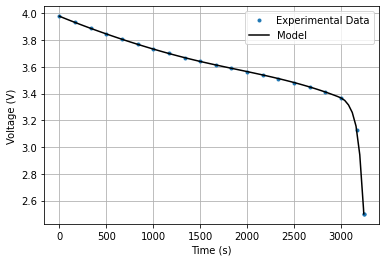

In [7]:
#  Load and plot the experimental data
data = np.loadtxt('experimental_data.dat')
plt.plot(data[:,0], data[:,1], '.', label = 'Experimental Data')

#  Create the model and run the fit
model = Battery_Model()
p = model.do_fit()
D_p = 10**p[0]
S_p = 10**p[1]
S_n = 10**p[2]

#  Run a simulation using our fitted parameters and plot the results
model.run_simulation(D_p, S_p, S_n)
plt.plot(model.t, model.V, 'k', label = 'Model')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()